### Capture zones of wells in uniform flow

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as npp

In [2]:
def wdisfunc(z, zw, Qw, Wu):
    '''
    z : location(s) where to compute discharge vector, complex (array)
    zw : locations of wells, complex array
    Qw : discharges of wells, real array
    Wu : uniform background flow, complex
    '''
    wdis = Wu
    for i in range(len(zw)):
        wdis += -Qw[i] / (2 * np.pi) / (z - zw[i])
    return wdis.real, -wdis.imag

def stagnation_points(zw, Qw, Wu):
    '''
    zw : locations of wells, complex array
    Qw : discharges of wells, real array
    Wu : uniform background flow, complex
    '''
    poly = Wu * npp.Polynomial(npp.polyfromroots(zw))
    index = np.arange(len(zw))
    for n in range(len(zw)):
        poly -= Qw[n] / (2 * np.pi) * npp.Polynomial(
            npp.polyfromroots(zw[index[index != n]]))
    return poly.roots()

In [3]:
# specify wells and uniform flow
Wu = 0.4 - 0.3j # uniform flow, m^2/d
Qw = np.array([100, 100, 50, 150, 100]) # discharge of wells, m^3/d
zw = np.array([-75 + 0j, 50 + 50j, -50 + 100j, -150 - 25j, 0 - 100j]) # complex locations of wells, m

# specify grid to compute discharge vector
x1, x2 = -250, 150 # window size in x-direction, m
y1, y2 = -200, 200 # window size in y-direction, m
ng = 400 # number of grid points

In [4]:
zsp = stagnation_points(zw, Qw, Wu) # compute stagnation points
eps = 0.5 # distance from stagnation points to start streamlines, m
zstart = np.hstack((zsp + eps * np.exp(np.pi * 1j / 4),
                    zsp + eps * np.exp(np.pi * 5j / 4))) # complex starting locations
start = [(zstart[i].real, zstart[i].imag) for i in range(len(zstart))] # real array with starting locations
xg, yg = np.meshgrid(np.linspace(x1, x2, ng), np.linspace(y1, y2, ng))
zg = xg + yg * 1j
Qx, Qy = wdisfunc(zg, zw, Qw, Wu) # components of discharge vector on grid

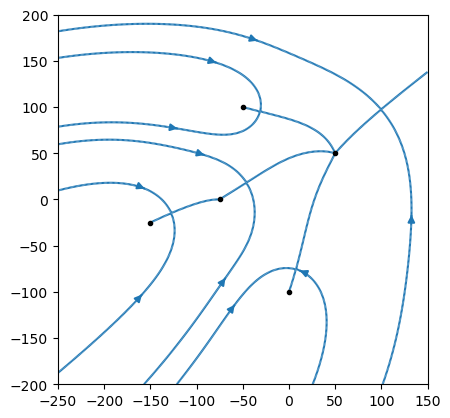

In [5]:
plt.subplot(111, aspect=1) # create figure with equal aspect ratio
plt.streamplot(xg, yg, Qx, Qy, start_points=start, 
               density=10, integration_direction='both')
plt.plot(zw.real, zw.imag, 'k.');

In [6]:
def potential(z, zw, Qw, N1, alpha1, N2, alpha2, Wu):
    zbar = z.conjugate()
    pot = -N1 / 8 * (np.exp(-2 * 1j * alpha1) * z ** 2 +
                     np.exp(2 * 1j * alpha1) * zbar ** 2 +
                     2 * z * zbar)
    pot += -N2 / 8 * (np.exp(-2 * 1j * alpha2) * z ** 2 +
                     np.exp(2 * 1j * alpha2) * zbar ** 2 +
                     2 * z * zbar)
    pot -= Wu * z
    for i in range(len(zw)):
        pot += Qw[i] / (2 * np.pi) * np.log(z - zw[i])
    return pot.real

def wdis(z, zw, Qw, A, B, C):
    w = A * z + B * z.conjugate() + C
    for i in range(len(zw)):
        w -= Qw[i] / (2 * np.pi) / (z - zw[i])
    return np.array([w.real, -w.imag])

def abc(N1, alpha1, N2, alpha2, Wu):
    a = N1 / 2 * np.exp(-2 * alpha1 * 1j) + \
        N2 / 2 * np.exp(-2 * alpha2 * 1j)
    b = (N1 + N2) / 2
    c = Wu
    return a, b, c

def Fpol(zw, Qw):
    Nwells = len(zw)
    index = np.arange(Nwells)
    pol = 0
    for n in range(Nwells):
        pol = pol +  Qw[n] / (2 * np.pi) * npp.Polynomial(
            npp.polyfromroots(zw[index[index != n]]))
    return pol

def Ppol(zw):
    return npp.Polynomial(npp.polyfromroots(zw))

def Fpolstar(zw, Qw, A, B, C):
    Nwells = len(zw)
    index = np.arange(Nwells)
    zwbar = zw.conjugate()
    F = Fpol(zw, Qw)
    P = Ppol(zw)
    z = npp.Polynomial((0, 1))
    pollist = []
    for n in range(Nwells):
        pol = F - (A * z + C + B * zwbar[n]) * P
        pollist.append(pol)
    pollist = np.array(pollist) # make object array
    pol = 0
    for p in range(Nwells):
        pol = pol + Qw[p] / (2 * np.pi) * np.prod(pollist[index[index != p]])
    return pol

def Ppolstar(zw, Qw, A, B, C):
    Nwells = len(zw)
    index = np.arange(Nwells)
    zwbar = zw.conjugate()
    F = Fpol(zw, Qw)
    P = Ppol(zw)
    z = npp.Polynomial((0, 1))
    pollist = []
    for n in range(Nwells):
        pol = F - (A * z + C + B * zwbar[n]) * P
        pollist.append(pol)
    pollist = np.array(pollist) # make object array
    return np.prod(pollist)

def Pol(zw, Qw, A, B, C):
    F = Fpol(zw, Qw)
    P = Ppol(zw)
    Fstar = Fpolstar(zw, Qw, A, B, C)
    Pstar = Ppolstar(zw, Qw, A, B, C)
    Abar = A.conjugate()
    Bbar = B.conjugate()
    Cbar = C.conjugate()
    z = npp.Polynomial((0, 1))
    pol = (Abar * F - Abar * A * z * P - Abar * C * P  + Bbar * B * z * P + Cbar * B * P) * Pstar - B ** 2 * Fstar * P ** 2
    return pol

In [7]:
# define recharge
N1 = 0.001
N2 = 0.001
alpha1 = 0
alpha2 = np.pi / 2
Wu = 0
a, b, c =  abc(N1, alpha1, N2, alpha2, Wu)
# specify grid to compute discharge vector
x1, x2 = -400, 350 # window size in x-direction, m
y1, y2 = -500, 400 # window size in y-direction, m
ng = 400 # number of grid points

In [8]:
pol = Pol(zw, Qw, a, b, c)
zr = pol.roots()
zsp = [] # list of stagnation points
zsh = [] # list of high points
for zs in zr:
    if np.sqrt(np.sum(wdis(zs, zw, Qw, a, b, c) ** 2)) < 1e-5:
        if np.any(potential(zs + eps * np.exp(np.arange(0, 2 * np.pi, np.pi / 4) * 1j),
          zw, Qw, N1, alpha1, N2, alpha2, Wu) - potential(zs, zw, Qw, N1, alpha1, N2, alpha2, Wu) > 0):
            zsp.append(zs)
        else:
            zsh.append(zs)
zsh = np.array(zsh)

eps = 0.5 # distance from stagnation points to start streamlines, m
zstart = np.hstack((zsp + eps * np.exp(np.pi * 1j / 4),
                    zsp + eps * np.exp(np.pi * 5j / 4))) # complex starting locations
start = [(zstart[i].real, zstart[i].imag) for i in range(len(zstart))] # real array with starting locations

xg, yg = np.meshgrid(np.linspace(x1, x2, ng), np.linspace(y1, y2, ng))
zg = xg + yg * 1j
Qx, Qy = wdis(zg, zw, Qw, a, b, c) # components of discharge vector on grid

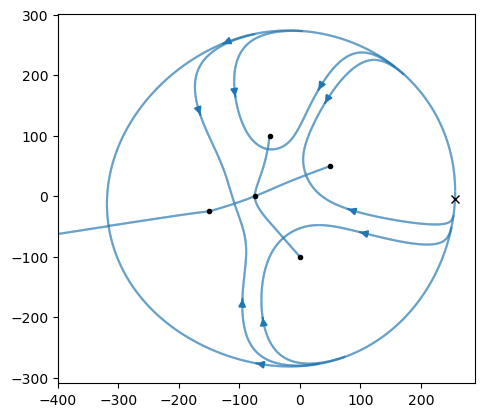

In [9]:
plt.subplot(111, aspect=1) # create figure with equal aspect ratio
plt.streamplot(xg, yg, Qx, Qy, start_points=start, 
               density=100, integration_direction='both')
plt.plot(zw.real, zw.imag, 'k.')
plt.plot(zsh.real, zsh.imag, 'kx');